#**Universidad Galileo**
##Statistical Learning II - Proyecto Recurrent Neural Network
###César Luis Polanco
###20062088

# Analisis de sentimiento
<br>

## Contexto

Sentiment Analysis es una aplicación del procesamiento natural del lenguaje (NLP) que identifica el tono u opinión emocional o sentimental de un corpus de texto.

## Objetivo
Para esta parte del proyecto se estará un análisis de sentimiento del script de Harry Potter y la piedra filosofal.

In [ ]:
!pip install NRCLex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 396 kB 25.3 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=ca60aabeef9867d0266045cbe71096211b18d2a9762fb7227e0829813cdce18e
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


In [ ]:
#Cargar libreria
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nrclex import NRCLex
from collections import Counter
import nltk
from PIL import Image
from wordcloud import WordCloud
import os

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Carga de script Harry Potter

In [ ]:
#Mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dir =  '/content/drive/MyDrive/SL2/RNN/'
dir_checkpoint = os.path.dirname('/content/drive/MyDrive/SL2/RNN/checkpoint')

In [ ]:
df = pd.read_csv(dir+'hp/hp_script.csv', encoding='cp1252')

## Análisis exploratorio

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df_len = len(df)
df.isna().sum() /df_len 

In [ ]:
character_name = np.unique(df['character_name'])
character_name

## Preprocesamiento de texto

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer

In [ ]:
def text_preprocess(dialogue):
    dialogue=str(dialogue)
    dialogue = dialogue.lower()
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', dialogue)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(cleantext)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words = [PorterStemmer().stem(w) for w in filtered_words]
    lemma_words=[WordNetLemmatizer().lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [ ]:
df['cleanText']=df['dialogue'].map(lambda x:text_preprocess(x))

In [ ]:
df.head()

In [ ]:
common_words = Counter(" ".join(df['cleanText']).split()).most_common(10)
common_words

In [ ]:
mask = np.array(Image.open(dir+'hp/snitch2.png'))

In [ ]:
words = " ".join(line for line in df["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=5, mask=mask).generate(words)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Implementación de emociones

Para la implementación de emociones se buscó un dataset de twitter donde se pudiera obtener la clasificación de emociones.

In [ ]:
twitter = pd.read_csv(dir+'/hp/text_emotion.csv',encoding='cp1252')

In [ ]:
twitter.head()

In [ ]:
twitter = twitter.drop(['tweet_id', 'author'], axis=1)
twitter.head()

In [ ]:
twitter['cleanText']=twitter['content'].map(lambda x:text_preprocess(x))

In [ ]:
twitter['clean_wordcount'] = twitter['cleanText'].map(lambda x:len(re.findall(r'\w+', x)))
filtered_twit = twitter[twitter['clean_wordcount'] > 2]

In [ ]:
filtered_twit.head()

In [ ]:
x = filtered_twit['cleanText']
y = pd.get_dummies(filtered_twit['sentiment']).values

In [ ]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(x.values)
vocabulary_size = len(tokenizer.word_counts.keys())+1
X = tokenizer.texts_to_sequences(x.values)
X = pad_sequences(X)

In [ ]:
vocabulary_size = len(tokenizer.word_counts.keys())+1

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 10)
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

## Definición del modelo

In [ ]:
embed_dim = 32
lstm_out = 32
batch_size = 32

In [ ]:
model = Sequential([
    layers.Embedding(vocabulary_size, embed_dim,input_length = x_train.shape[1]),
    layers.SpatialDropout1D(0.2),
    layers.LSTM(200),
    layers.Dense(units=13, activation='softmax')
])
model.compile(loss = 'categorical_crossentropy', optimizer='Nadam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 32)            1464352   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 19, 32)           0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 200)               186400    
                                                                 
 dense_3 (Dense)             (None, 13)                2613      
                                                                 
Total params: 1,653,365
Trainable params: 1,653,365
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
checkpoint = ModelCheckpoint(filepath=dir_checkpoint,
                             monitor = 'val_accuracy',
                             verbose=1, 
                             save_best_onlya=True,)

In [ ]:
history = model.fit(x_train, y_train, epochs=8,validation_data=(x_val, y_val),callbacks=[checkpoint], batch_size=batch_size)

Epoch 1/8
920/920 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.8060
Epoch 1: saving model to /content/drive/MyDrive/SL2/RNN


920/920 [==============================] - 70s 76ms/step - loss: 0.5708 - accuracy: 0.8060 - val_loss: 4.0432 - val_accuracy: 0.2669
Epoch 2/8
920/920 [==============================] - ETA: 0s - loss: 0.5739 - accuracy: 0.8051
Epoch 2: saving model to /content/drive/MyDrive/SL2/RNN


920/920 [==============================] - 66s 72ms/step - loss: 0.5739 - accuracy: 0.8051 - val_loss: 4.0938 - val_accuracy: 0.2593
Epoch 3/8
920/920 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.8086
Epoch 3: saving model to /content/drive/MyDrive/SL2/RNN


920/920 [==============================] - 68s 74ms/step - loss: 0.5579 - accuracy: 0.8086 - val_loss: 4.1198 - val_accuracy: 0.2647
Epoch 4/8
920/920 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.8089
Epoch 4: saving model to /content/drive/MyDrive/SL2/RNN


920/920 [==============================] - 70s 76ms/step - loss: 0.5598 - accuracy: 0.8089 - val_loss: 4.0578 - val_accuracy: 0.2589
Epoch 5/8
920/920 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.8090
Epoch 5: saving model to /content/drive/MyDrive/SL2/RNN


920/920 [==============================] - 67s 73ms/step - loss: 0.5600 - accuracy: 0.8090 - val_loss: 4.0916 - val_accuracy: 0.2603
Epoch 6/8
920/920 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.8155
Epoch 6: saving model to /content/drive/MyDrive/SL2/RNN


920/920 [==============================] - 72s 78ms/step - loss: 0.5465 - accuracy: 0.8155 - val_loss: 4.0566 - val_accuracy: 0.2577
Epoch 7/8
920/920 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.8149
Epoch 7: saving model to /content/drive/MyDrive/SL2/RNN


920/920 [==============================] - 69s 76ms/step - loss: 0.5395 - accuracy: 0.8149 - val_loss: 4.1586 - val_accuracy: 0.2586
Epoch 8/8
920/920 [==============================] - ETA: 0s - loss: 0.5432 - accuracy: 0.8143
Epoch 8: saving model to /content/drive/MyDrive/SL2/RNN


920/920 [==============================] - 67s 73ms/step - loss: 0.5432 - accuracy: 0.8143 - val_loss: 4.1428 - val_accuracy: 0.2536


## Guardar modelo

In [ ]:
model.save(dir+'RNN_Model')

## Cargar modelo

In [ ]:
model.load_weights(dir+'RNN_Model')

## Graficar modelo

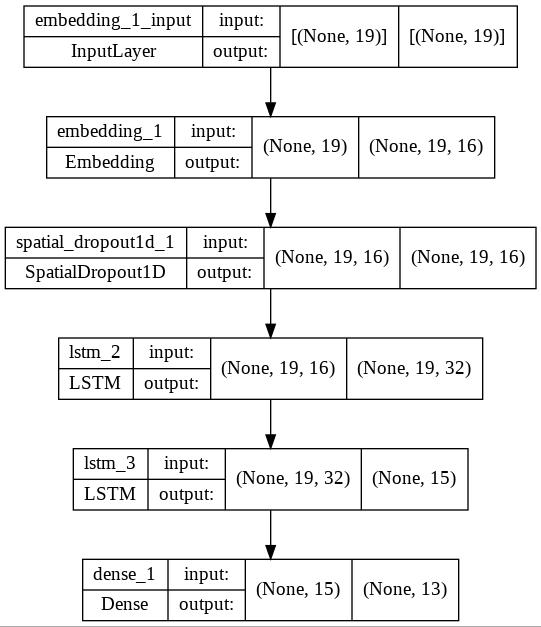

In [ ]:
keras.utils.plot_model(model, to_file="RNN_Model.jpg", show_shapes=True)

## Precisión del modelo

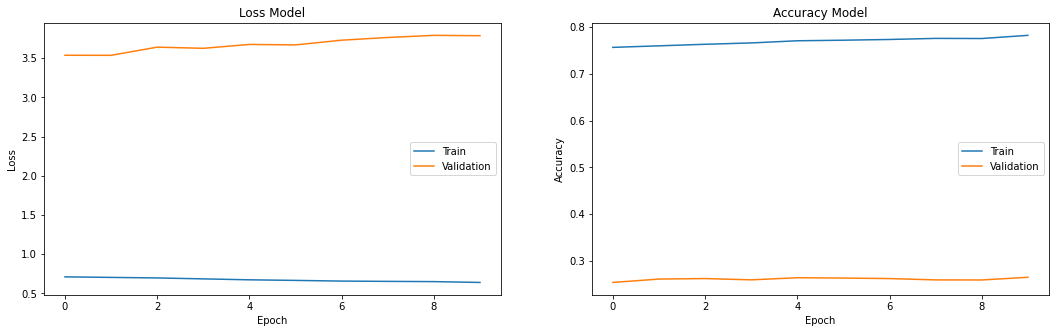

In [ ]:
plt.figure(figsize=(18, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Implementación de modelo

In [ ]:
def get_sentiment(str):
  sentiments = np.unique(filtered_twit['sentiment'])
  token = tokenizer.texts_to_sequences(str.split("-_-"))
  token = pad_sequences(token, maxlen=19, dtype='int32', value=0)
  sentiment = model.predict(token,batch_size=1,verbose=2)
  str_sentiment = sentiments[np.argmax(sentiment)]
  return str_sentiment

## Crear nuevo dataframe

In [ ]:
df_yhat = df
df_yhat.head()

,ID_number,scene,character_name,dialogue,cleanText,sentiment_predicted
0,1,1,Albus Dumbledore,"I should have known that you would be here, Pr...",known would professor mcgonagall,neutral
1,2,1,Minerva McGonagall,"Good evening, Professor Dumbledore. Are the ru...",good evening professor dumbledore rumours true...,happiness
2,3,1,Albus Dumbledore,"I'm afraid so, Professor. The good, and the bad.",afraid professor good bad,worry
3,4,1,Minerva McGonagall,And the boy?,boy,neutral
4,5,1,Albus Dumbledore,Hagrid is bringing him.,hagrid bringing,neutral


## Obtener sentimiento respecto al dialogo

In [ ]:
df_yhat['sentiment_predicted'] = df_yhat['cleanText'].map(lambda x:get_sentiment(x))

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16m

In [ ]:
df_yhat.head(30)

,ID_number,scene,character_name,dialogue,cleanText,sentiment_predicted
0,1,1,Albus Dumbledore,"I should have known that you would be here, Pr...",known would professor mcgonagall,neutral
1,2,1,Minerva McGonagall,"Good evening, Professor Dumbledore. Are the ru...",good evening professor dumbledore rumours true...,happiness
2,3,1,Albus Dumbledore,"I'm afraid so, Professor. The good, and the bad.",afraid professor good bad,worry
3,4,1,Minerva McGonagall,And the boy?,boy,neutral
4,5,1,Albus Dumbledore,Hagrid is bringing him.,hagrid bringing,neutral
5,6,1,Minerva McGonagall,Do you think it wise to trust Hagrid with some...,think wise trust hagrid something important,happiness
6,7,1,Albus Dumbledore,"Ah, Professor, I would trust Hagrid with my life.",professor would trust hagrid life,love
7,8,1,Rubeus Hagrid,"Professor Dumbledore, Sir. Professor McGonagall.",professor dumbledore sir professor mcgonagall,neutral
8,9,1,Albus Dumbledore,"No problems, I trust, Hagrid?",problems trust hagrid,worry
9,10,1,Rubeus Hagrid,"No, Sir. Little tyke fell asleep just as we we...",sir little tyke fell asleep flying bristol heh...,sadness


## Frecuencia Sentimientos

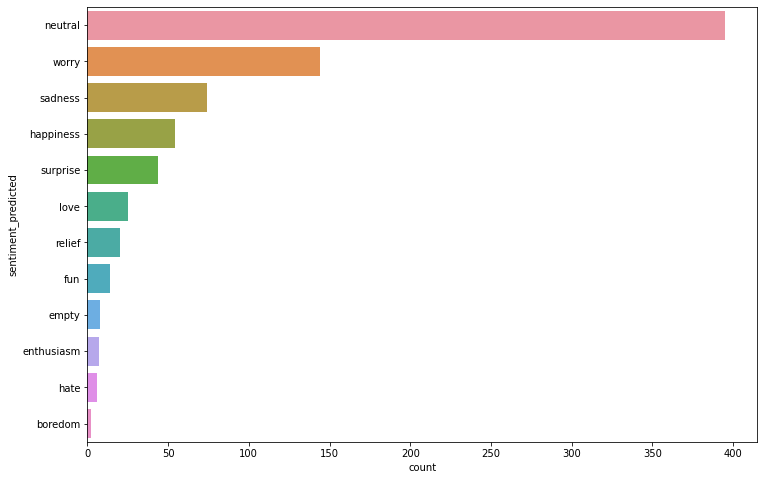

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(y="sentiment_predicted",data=df_yhat, orient='h', order = df_yhat['sentiment_predicted'].value_counts().index)

## Creación de subset

In [ ]:
df_love = df_yhat[df_yhat['sentiment_predicted']=='love']
df_sad = df_yhat[df_yhat['sentiment_predicted']=='sadness']
df_worry = df_yhat[df_yhat['sentiment_predicted']=='worry']
df_happy = df_yhat[df_yhat['sentiment_predicted']=='happiness']

## Personajes con dialogo de *Amor*

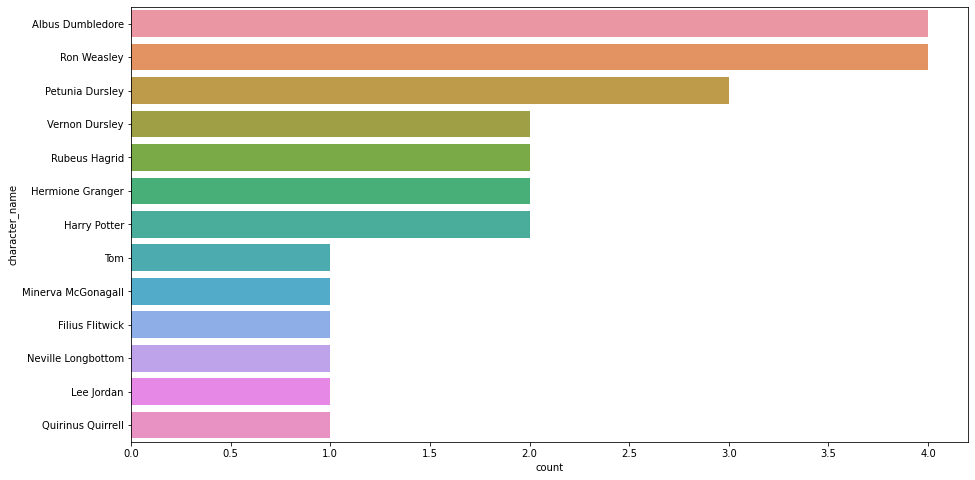

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="character_name",data=df_love, orient='h', order = df_love['character_name'].value_counts().index)

In [ ]:
df_love.head(20)

,ID_number,scene,character_name,dialogue,cleanText,sentiment_predicted
6,7,1,Albus Dumbledore,"Ah, Professor, I would trust Hagrid with my life.",professor would trust hagrid life,love
13,14,1,Albus Dumbledore,Exactly. He's far better off growing up away f...,exactly far better growing away ready,love
22,23,2,Petunia Dursley,I want everything to be perfect for my Dudley'...,want everything perfect dudley special day,love
31,32,2,Petunia Dursley,"Oh, now, now, now. This is what we're going to...",going going buy two new presents pumpkin,love
32,33,2,Petunia Dursley,This will be a lovely day at the zoo. I'm real...,lovely day zoo really looking forward,love
55,56,3,Vernon Dursley,There's no such thing as magic!,thing magic,love
107,108,4,Rubeus Hagrid,Non magic folk. This boy's had his name down e...,non magic folk boy name ever since born going ...,love
108,109,4,Vernon Dursley,I will not pay for some crackpot old fool to t...,pay crackpot old fool teach magic tricks,love
118,119,5,Tom,Bless my soul. It's Harry Potter.,bless soul harry potter,love
183,184,10,Ron Weasley,"So-so it's true? I mean, do you really have th...",true mean really,love


## Personajes con dialogo de *Tristeza*

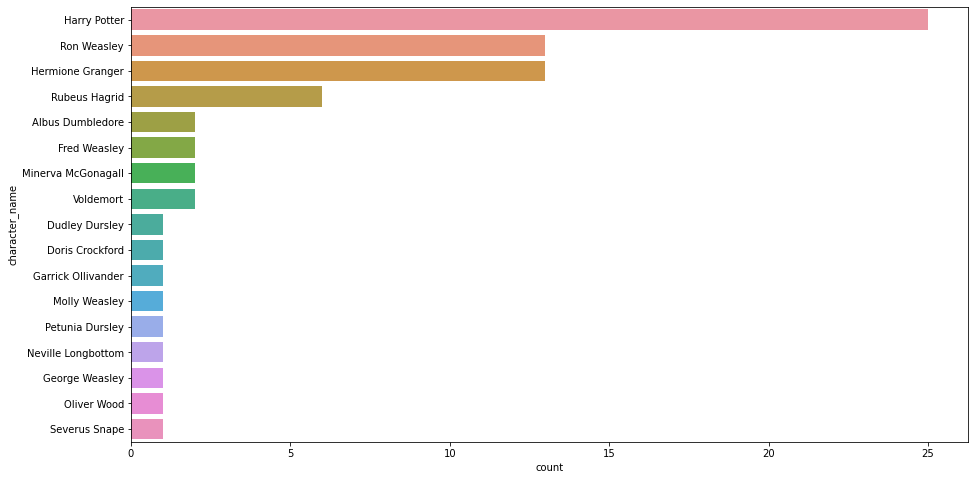

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="character_name",data=df_sad, orient='h', order = df_sad['character_name'].value_counts().index)

In [ ]:
df_sad.head(20)

,ID_number,scene,character_name,dialogue,cleanText,sentiment_predicted
9,10,1,Rubeus Hagrid,"No, Sir. Little tyke fell asleep just as we we...",sir little tyke fell asleep flying bristol heh...,sadness
14,15,1,Albus Dumbledore,"There there, Hagrid. It's not really goodbye, ...",hagrid really goodbye,sadness
18,19,2,Petunia Dursley,"Oh, here he comes, the birthday boy!",comes birthday boy,sadness
41,42,2,Harry Potter,"You're from Burma, aren't you? Was it nice the...",burma nice miss family,sadness
42,43,2,Harry Potter,I see. That's me as well. I never knew my pare...,see well never knew parents either,sadness
47,48,2,Dudley Dursley,"Mum, mummy!",mum mummy,sadness
72,73,3,Harry Potter,They're my letters! Let go of me!,letters let,sadness
87,88,4,Rubeus Hagrid,Rubeus Hagrid. Keeper of keys and grounds at H...,rubeus hagrid keeper keys grounds hogwarts cou...,sadness
88,89,4,Harry Potter,"Sorry, no.",sorry,sadness
95,96,4,Rubeus Hagrid,"Well, just Harry. Did you ever make anything h...",well harry ever make anything happen anything ...,sadness


## Personajes con dialogo de *Preocupación*

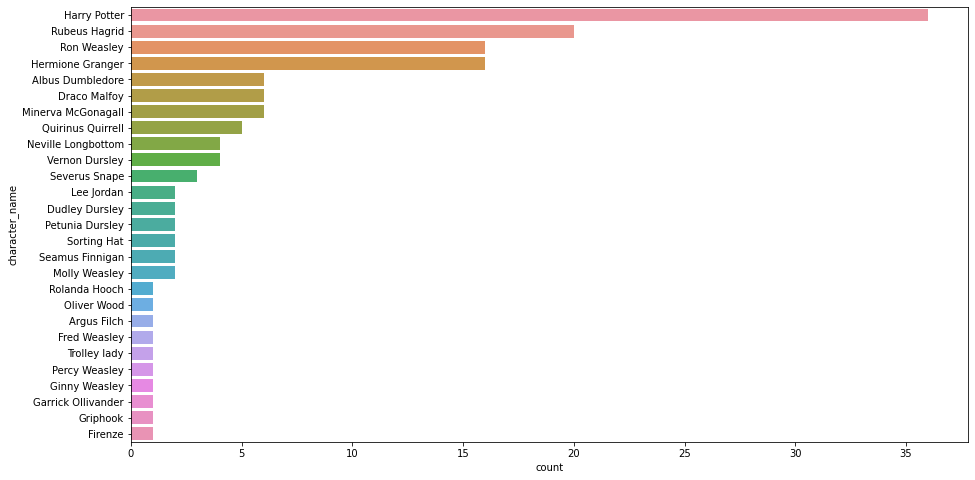

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="character_name",data=df_worry, orient='h', order = df_worry['character_name'].value_counts().index)

In [ ]:
df_worry.head(20)

,ID_number,scene,character_name,dialogue,cleanText,sentiment_predicted
2,3,1,Albus Dumbledore,"I'm afraid so, Professor. The good, and the bad.",afraid professor good bad,worry
8,9,1,Albus Dumbledore,"No problems, I trust, Hagrid?",problems trust hagrid,worry
10,11,1,Minerva McGonagall,"Albus, do you really think it's safe, leaving ...",albus really think safe leaving people watched...,worry
12,13,1,Minerva McGonagall,This boy will be famous. There won't be a chil...,boy famous child world know name,worry
15,16,1,Albus Dumbledore,"Good luck, Harry Potter.",good luck harry potter,worry
20,21,2,Petunia Dursley,"Why don't you just cook the breakfast, and try...",cook breakfast try burn anything,worry
27,28,2,Vernon Dursley,Thirty-six. Counted them myself.,thirty six counted,worry
39,40,2,Harry Potter,Sorry about him. He doesn't understand what it...,sorry understand like lying day day people pre...,worry
43,44,2,Dudley Dursley,"Mummy, dad, come here! You won't believe what ...",mummy dad come believe snake,worry
50,51,2,Petunia Dursley,My darling boy! How did you get in there?! How...,darling boy get get dursley dursley,worry


## Personajes con dialogo de *Alegría*

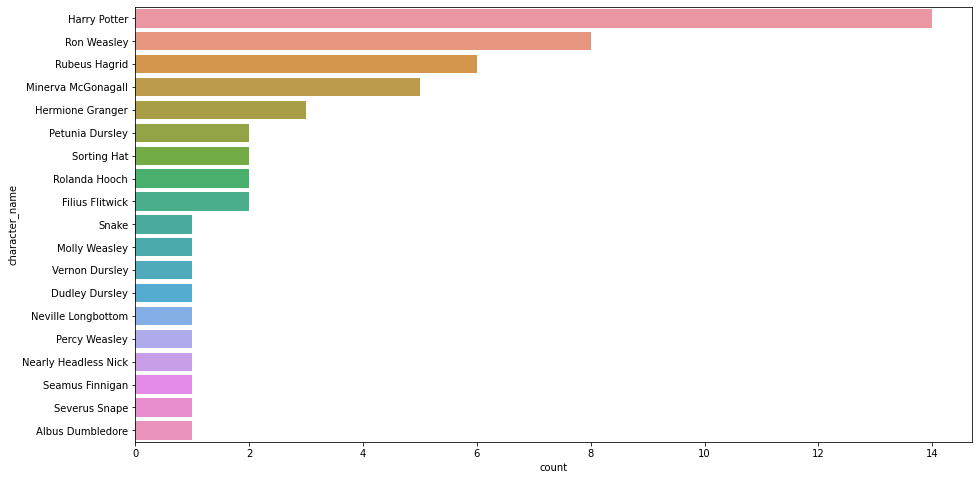

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="character_name",data=df_happy, orient='h', order = df_happy['character_name'].value_counts().index)

In [ ]:
df_happy.head(20)

,ID_number,scene,character_name,dialogue,cleanText,sentiment_predicted
1,2,1,Minerva McGonagall,"Good evening, Professor Dumbledore. Are the ru...",good evening professor dumbledore rumours true...,happiness
5,6,1,Minerva McGonagall,Do you think it wise to trust Hagrid with some...,think wise trust hagrid something important,happiness
17,18,2,Dudley Dursley,"Wake up, cousin! We're going to the zoo!",wake cousin going zoo,happiness
19,20,2,Vernon Dursley,"Happy birthday, son.",happy birthday son,happiness
25,26,2,Petunia Dursley,"Aren't they wonderful, darling?",wonderful darling,happiness
45,46,2,Snake,Thanks.,thanks,happiness
54,55,3,Harry Potter,"I swear I don't know! One minute, the glass wa...",swear know one minute glass gone like magic,happiness
83,84,4,Rubeus Hagrid,"Oh, well, of course you are! Got something for...",well course got something fraid might sat poin...,happiness
84,85,4,Harry Potter,Thank you!,thank,happiness
99,100,4,Petunia Dursley,Of course we knew. How could you not be? My pe...,course knew could perfect sister mother father...,happiness


## Conclusiones

Durante la implementación se tuvo bastantes retos en la implementación de RNN ya que se tuvo que realizar múltiples experimentos para poder obtener los sentimientos.

Se realizó con un entrenamiento alterno, empleando información de Twitter para entrenar el modelo, el cual tiene una precisión del >80%. 

Como lecciones aprendidas, es importante realizar el dropout para que no se genere el sobre ajuste del modelo ya que las primeras iteraciones se tenía una precisión del 98%

Con el modelo implementado se logró realizar el análisis de sentimiento de la película Harry Potter y la prieda filosofal.